In [51]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy as sc
from scipy.optimize import minimize
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from scipy.optimize import newton
from scipy.optimize import root_scalar
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.collections import LineCollection
from matplotlib import colors
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D

In [52]:
e      = 1.6*10**(-19)              #Charge of electron
hbar   = 1.054 * 10**(-34)          #SI  Js 
hbarev = 6.59*10**(-16)             #SI  eVs
me     = 9.1 * 10**(-31)            #SI  kg
meff   = 0.035*me                   #SI  kg
kb     = 1.38 * 10**(-23)           #SI  J/K
kbev   = 8.617 * 10**(-5)           #SI  eV/K
c      = 3*(10**8)                  #SI  m/s

omega  = 0.110                      #SI eV  interlayer hopping energy 
d      = 1.420 *10**(-10)           #SI m  C-C distance in graphene
vf     = 1.5*d*2.866/hbarev         #SI m/s, Fermi velocity for SLG  = 0.905 *10**(6)  #CORRECTED 2.866 for MA=1.05
N      = 1000                       #No. of landau leveles
N_con  = 500                        #No. of landau levels considering (should be less than or equal to N)

In [53]:
upper=Qobj([[0,1],[0,0]])
lower=Qobj([[0,0],[1,0]])

def hk_mono_LS(N_con,B,qx,qy,pos):              #Landau splitting about the dirac point of monolayer with respect to cyclotron frequency ,qx and qy are shifts
    
    lB = np.sqrt(hbar/(e*B))
    anhi     = destroy(N_con)
    
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 
    
    
    kx=0.5*(anhi+anhi.dag())/M_fac
    ky=0.5j*(anhi-anhi.dag())/M_fac
    
    hk=E_fac*(tensor((kx+qx)+1j*(ky+qy),upper)+tensor((kx+qx)-1j*(ky+qy),lower)).full()
    
    eigenvalue,featurevector=np.linalg.eigh(hk)
    eig_vals_sorted = np.sort(eigenvalue)
    
    if pos:
        eig_vals_sorted = eig_vals_sorted[-N_con:]
        return np.array(eig_vals_sorted)           # Returns Positive Eigenvalues 
    
    return eig_vals_sorted               #eigvals here is in eV

def bi_hk(N_con,B,pos):
      
    lB = np.sqrt(hbar/(e*B))
    anhi     = destroy(N_con)
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 

    
    kx=0.5*(anhi+anhi.dag())/M_fac
    ky=0.5j*(anhi-anhi.dag())/M_fac
    
    
    bi_hk= -(hbar**2/(2*meff*e))*(tensor((kx+1j*ky)**2,upper)+tensor((kx-1j*ky)**2,lower)).full()
    
    eigenvalue,featurevector=np.linalg.eigh(bi_hk)
    eig_vals_sorted = np.sort(eigenvalue)
    
    if pos:
        eig_vals_sorted = eig_vals_sorted[-N_con:]
        return np.array(eig_vals_sorted)
    
    return eig_vals_sorted               #eigvals here is in eV




ei120  = np.cos(2*np.pi/3) + 1j*np.sin(2*np.pi/3)
ei240  = np.cos(2*np.pi/3) - 1j*np.sin(2*np.pi/3)

# Hopping matrices

Tqb    = omega*np.array([[1,1], [1,1]], dtype=complex)
Tqtr   = omega*np.array([[ei240, 1], [ei120, ei240]], dtype=complex)
Tqtl   = omega*np.array([[ei120, 1], [ei240, ei120]], dtype=complex)
TqbD   = np.array(np.matrix(Tqb).H)
TqtrD  = np.array(np.matrix(Tqtr).H)
TqtlD  = np.array(np.matrix(Tqtl).H)


def  Hk_twist_landau_spec(N,B,theta,N_con):   #8 Band hamiltonain  #gives eigenvalues only about K(or K') point of 1st layer
    
    
    anhi     = destroy(N)
    lB = np.sqrt(hbar/(e*B))
    
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 
    I_n   = identity(N)
    
    sin_half = np.sin(theta/2)
    cos_half = np.cos(theta/2)
    
    
    ktheta   = 8*np.pi*sin_half/3/np.sqrt(3)/d                   #SI m^-1

    # Hopping vectors in k space
    
    qb      = ktheta*np.array([0, -1])
    qtr     = ktheta*np.array([np.sqrt(3)/2,0.5])
    qtl     = ktheta*np.array([-np.sqrt(3)/2,0.5])
    
    Hk      = np.array(np.zeros((8*N, 8*N)), dtype=complex)
    
    kx      = 0.5*(anhi+anhi.dag())/M_fac
    ky      = 0.5j*(anhi-anhi.dag())/M_fac
    
    
    qx      =  kx
    qy      =  ky
    qx1     =  (kx+qb[0])
    qy1     =  (ky+qb[1])
    qx2     =  (kx+qtr[0])
    qy2     =  (ky+qtr[1])
    qx3     =  (kx+qtl[0])
    qy3     =  (ky+qtl[1])
    
    
    H11     = -E_fac*(tensor((qx+1j*qy),upper)+tensor((qx-1j*qy),lower)).full()  
    H22     = -E_fac*(tensor((qx1+1j*qy1),upper)+tensor((qx1-1j*qy1),lower)).full()
    H33     = -E_fac*(tensor((qx2+1j*qy2),upper)+tensor((qx2-1j*qy2),lower)).full()
    H44     = -E_fac*(tensor((qx3+1j*qy3),upper)+tensor((qx3-1j*qy3),lower)).full()

   
    Hk[0:2*N,0:2*N]       = H11
    Hk[2*N:4*N,2*N:4*N]   = H22
    Hk[4*N:6*N,4*N:6*N]   = H33
    Hk[6*N:8*N,6*N:8*N]   = H44
    Hk[0:2*N,2*N:4*N]     = tensor(I_n,Qobj(Tqb)).full()
    Hk[0:2*N,4*N:6*N]     = tensor(I_n,Qobj(Tqtr)).full()
    Hk[0:2*N,6*N:8*N]     = tensor(I_n,Qobj(Tqtl)).full()
    Hk[2*N:4*N,0:2*N]     = tensor(I_n,Qobj(TqbD)).full()
    Hk[4*N:6*N,0:2*N]     = tensor(I_n,Qobj(TqtrD)).full()
    Hk[6*N:8*N,0:2*N]     = tensor(I_n,Qobj(TqtlD)).full()
    

    Hk = csr_matrix(Hk, dtype=complex)
    
    eigenvalues, eigenvectors = eigsh(Hk, k=2*N_con, sigma=1e-8, tol=1e-12)   #Return just this for all eigenvalues
    final_eigenvalues = np.sort(np.abs(np.round(eigenvalues)))[::2]

    return final_eigenvalues                #eigvals here is in eV



In [54]:
def therm_prob_not_norm(T,E):
    Thermal_probs= np.exp(-E/(kbev*T)) #make sure E is in eV as kbev is in eV/K
    Z_state = np.sum(Thermal_probs)     
    return Thermal_probs/Z_state



def Vn_entropy_therm_prob(L):
    epsilon = 1e-15                   # Add small epsilon to avoid log(0)
    #S = -kbev*np.sum(np.where(L > 0, L * np.log(L + epsilon), 0))
    S = -np.sum(np.where(L > 0, L * np.log(L + epsilon), 0))
    return S


def find_root_newton(Prob_ref, E_test, T_guess, max_iter=5000, tol=1e-5):
    result = newton(func=lambda T: entropy_difference(T, Prob_ref, E_test), x0=T_guess, fprime=None, tol=tol, maxiter=max_iter)
    return result


def find_temperature(Prob_ref, E_test,T_guess, T_bounds=(1e-3, 1000)):
    """Find temperature where S(T) = S_ref using Brent's method"""
    try:
        result = root_scalar(
            lambda T: entropy_difference(T, Prob_ref, E_test),
            bracket=T_bounds,
            method='brentq',
            xtol=1e-6
        )
        return result.root
    except ValueError:
        print(f"Failed to converge for E_test={E_test}, trying fallback...")
        return find_root_newton(Prob_ref, E_test, T_guess)      # Fallback to Newton with good guess

def Heat(E,P1,P2):
    Q=np.sum(E*(P1-P2))
    return Q     #in eV if E is in eV

def Work_sys(P,E1,E2):
    W=np.sum(P*(E1-E2))
    return W     #in eV if E is in eV


def entropy_difference(T_test, Prob_ref, E_test):
    Prob_test = therm_prob_not_norm(T_test,E_test)

    S_ref = Vn_entropy_therm_prob(Prob_ref).real
    S_test = Vn_entropy_therm_prob(Prob_test).real

    return S_ref - S_test 

In [55]:
def QOC_General(B1, Energy_B1, rc, theta, T_cold, T_hot,Type,saved):
    
    B2 = B1 * rc
    Prob_A = therm_prob_not_norm(T_cold, Energy_B1)

    try:
        if Type=="Performance":
            
            if saved == True:
            
                if isinstance(theta, (int, float)): 
                    filename = f"spectrum_B_1T_N{N}_theta{np.round(np.degrees(theta),2)}_Ncon{N_con}_rc1000.npz"  #NEW PART
                    data = np.load(filename)
                    B_vals = data["B_vals"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(B_vals - B2))
                    Energy_B2 = spectra[idx]
        
                else: 
                    filename = f"spectrum_B_1T_N{N}_theta{theta}_Ncon{N_con}_rc1000.npz"
                    data = np.load(filename)
                    B_vals = data["B_vals"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(B_vals - B2))
                    Energy_B2 = spectra[idx]
        
                
            else:
            
                if isinstance(theta, (int, float)): 
                    Energy_B2 = Hk_twist_landau_spec(N,B2,theta,N_con)
                    
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)


        elif Type=="Twist":
            
            if saved == True:
            
                if isinstance(theta, (int, float)): 
                    data = np.load(f"spectrum_theta_sweep_N{N}_rc{rc}_Ncon{N_con}_steps80.npz")
                    theta_vals_deg = data["theta_vals_deg"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(theta_vals_deg - np.round(np.degrees(theta),2)))
                    closest_theta = theta_vals_deg[idx]
                    Energy_B2 = spectra[idx]
                
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)

            else :
                
                if isinstance(theta, (int, float)): 
                    Energy_B2 = Hk_twist_landau_spec(N,B2,theta,N_con)
                    
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)
            
            
        Prob_ref = Prob_A
        E_test = Energy_B2

        T_2 = find_temperature(Prob_ref, E_test, all_T_2[-1])        
        
        all_T_2.append(T_2)

        Prob_B = therm_prob_not_norm(T_2, Energy_B2)
        Prob_C = therm_prob_not_norm(T_hot, Energy_B2)

        Prob_ref = Prob_C
        E_test = Energy_B1
        
        T_4 = find_temperature(Prob_ref, E_test, all_T_4[-1])
        
        
        all_T_4.append(T_4)
        
        if np.round(Vn_entropy_therm_prob(therm_prob_not_norm(T_4,Energy_B1))-Vn_entropy_therm_prob(therm_prob_not_norm(T_hot,Energy_B2)),3) !=0:
            raise "Entropy condition not met but T4 still found"
            
        if np.round(Vn_entropy_therm_prob(therm_prob_not_norm(T_2,Energy_B2))-Vn_entropy_therm_prob(therm_prob_not_norm(T_cold,Energy_B1)),3) !=0:
            raise "Entropy condition not met but T2 still found"

        Prob_D = therm_prob_not_norm(T_4, Energy_B1)

        Heat_in = Heat(Energy_B2, Prob_C, Prob_B).real
        Heat_out = Heat(Energy_B1, Prob_A, Prob_D).real
        Work = Heat_in + Heat_out
        eff = Work / Heat_in
        COP_R_CP = np.abs(Heat_out) / np.abs(Work)
        COP_JP = (np.abs(Heat_out) + np.abs(Heat_in)) / np.abs(Work)

        #print(f"{Count},T2 = {T_2:.2f}, T4 = {T_4:.2f}, Qi = {Heat_in:.6f}, Qo = {Heat_out:.6f}, "
        #      f"W = {Work:.6f}, ef = {eff:.4f}, Cp1 = {COP_R_CP:.3f}, Cp2 = {COP_JP:.3f}")

        return Heat_in, Heat_out, Work, eff, COP_R_CP, COP_JP

    except Exception as e:
        print(f"Skipping rc={rc} due to non-convergence: {e}")
        return None, None, None, None, None, None
    
    
def QOC_Strict(B1, Energy_B1, rc, theta, T_cold, T_hot,Type,saved):
    
    B2 = B1 * rc

    Prob_A = therm_prob_not_norm(T_cold, Energy_B1)

    try:
        if Type=="Performance":
            
            if saved == True :
            
                if isinstance(theta, (int, float)): 
                    filename = f"spectrum_B_1T_N{N}_theta{np.round(np.degrees(theta),2)}_Ncon{N_con}_rc1000.npz"  #NEW PART
                    data = np.load(filename)
                    B_vals = data["B_vals"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(B_vals - B2))
                    Energy_B2 = spectra[idx]
        
                else: 
                    filename = f"spectrum_B_1T_N{N}_theta{theta}_Ncon{N_con}_rc1000.npz"
                    data = np.load(filename)
                    B_vals = data["B_vals"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(B_vals - B2))
                    Energy_B2 = spectra[idx]
        
                
            else:
            
                if isinstance(theta, (int, float)): 
                    Energy_B2 = Hk_twist_landau_spec(N,B2,theta,N_con)
                    
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)


        elif Type=="Twist":
            
            if saved == True :
            
                if isinstance(theta, (int, float)): 
                    data = np.load(f"spectrum_theta_sweep_N{N}_rc{rc}_Ncon{N_con}_steps80.npz")
                    theta_vals_deg = data["theta_vals_deg"]
                    spectra = data["spectra"]
                    idx = np.argmin(np.abs(theta_vals_deg - np.round(np.degrees(theta),2)))
                    closest_theta = theta_vals_deg[idx]
                    Energy_B2 = spectra[idx]
                
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)

            else :
                
                if isinstance(theta, (int, float)): 
                    Energy_B2 = Hk_twist_landau_spec(N,B2,theta,N_con)
                    
                elif theta == "Monolayer":
                    Energy_B2 = hk_mono_LS(N_con, B2, 0, 0, True)
                    
                elif theta == "Bilayer":
                    Energy_B2 = bi_hk(N_con, B2, True)
                
                

        Prob_ref = Prob_A
        E_test = Energy_B2

        Prob_B = Prob_A
        Prob_C = therm_prob_not_norm(T_hot, Energy_B2)


        Prob_D = Prob_C

        Heat_in = Heat(Energy_B2, Prob_C, Prob_B).real
        Heat_out = Heat(Energy_B1, Prob_A, Prob_D).real
        Work=(Heat_in+Heat_out)
        eff = Work / Heat_in
        COP_R_CP = np.abs(Heat_out) / np.abs(Work)
        COP_JP = (np.abs(Heat_out) + np.abs(Heat_in)) / np.abs(Work)
        

        #print(f"{Count}, Qi = {Heat_in:.6f}, Qo = {Heat_out:.6f}, "
        #      f"W = {Work:.6f}, ef = {eff:.4f}, Cp1 = {COP_R_CP:.3f}, Cp2 = {COP_JP:.3f}")

        return Heat_in, Heat_out, Work, eff, COP_R_CP, COP_JP

    except Exception as e:
        print(f"Skipping rc={rc} due to non-convergence: {e}")
        return None, None, None, None, None, None


/var/folders/j9/mv8r31ws7gd9xn1rn1c8gjnr0000gn/T/ipykernel_85349/3760057994.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  COP_R_CP = np.abs(Heat_out) / np.abs(Work)
/var/folders/j9/mv8r31ws7gd9xn1rn1c8gjnr0000gn/T/ipykernel_85349/3760057994.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  COP_JP = (np.abs(Heat_out) + np.abs(Heat_in)) / np.abs(Work)


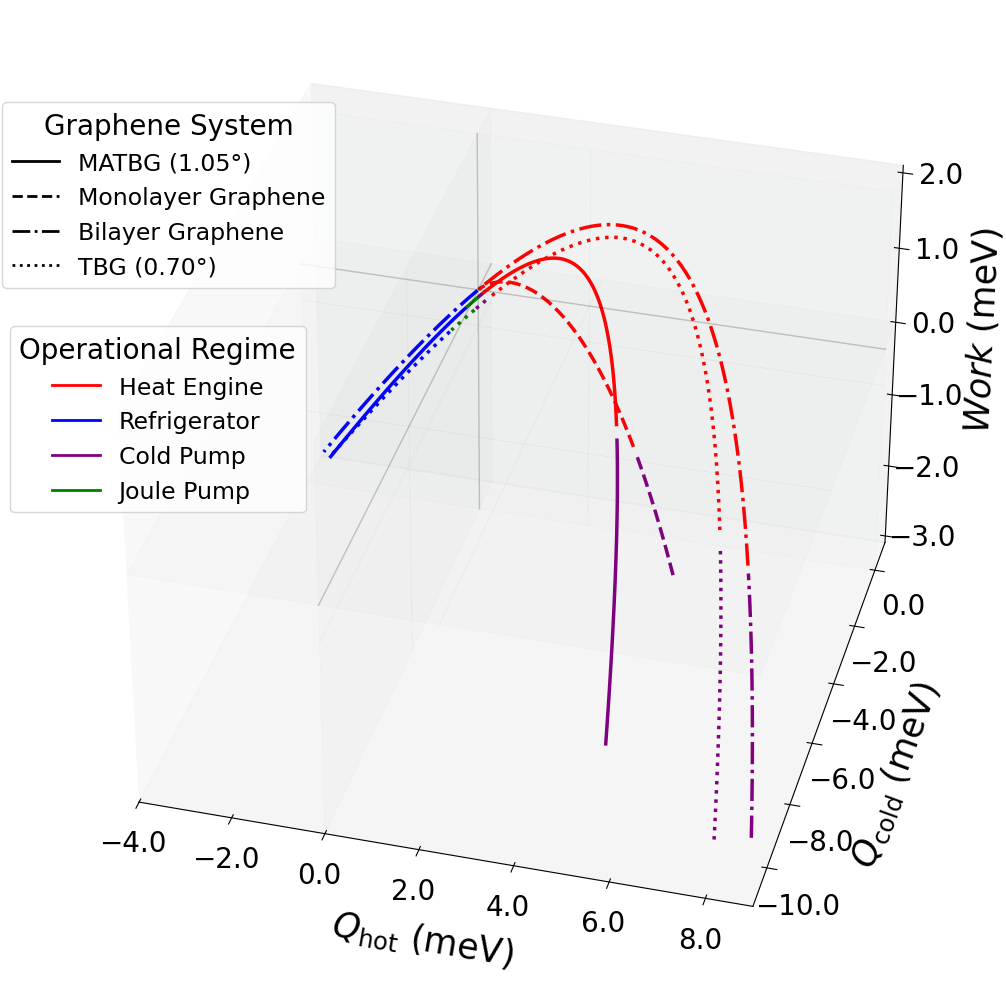

In [56]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Hot reservoir temperature (K)

B1 = 1  # Magnetic field in Tesla

Theta_deg = ["Monolayer","Bilayer",0.7,1.05]
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]

Ratio = np.linspace(0.8, 8, 935)

# Define regime colors and labels
regime_colors = {
    "engine": "red",
    "refrigerator": "blue",
    "cold_pump": "purple",
    "joule_pump": "green",
    "unknown": "gray"
}
regime_labels = {
    "engine": "Heat Engine",
    "refrigerator": "Refrigerator",
    "cold_pump": "Cold Pump",
    "joule_pump": "Joule Pump",
    "unknown": "Unknown"
}

# Define line styles for each theta type
theta_line_styles = {
    "Monolayer": "--",  # dashed line
    "Bilayer": "-.",    # dash-dot line
    0.70: ":" ,          # solid line
    1.05: "-"           # solid line
}

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)

all_Qin_data = []
all_Qout_data = []
all_work_data = []

present_regimes = set()

for theta in Theta:
    
    all_Qin = []
    all_Qout = []
    all_work = []
    heat_categories = []
    
    all_T_4, all_T_2 = [], []
    all_T_2.append(T_cold)
    all_T_4.append(T_hot)

    Count = 0
        
    if isinstance(theta, (int, float)):
        filename = f"spectrum_B_1T_N{N}_theta{np.round(np.degrees(theta),2)}_Ncon{N_con}_rc1000.npz"
        data = np.load(filename)
        B_vals = data["B_vals"]
        spectra = data["spectra"]    
        idx = np.argmin(np.abs(B_vals - B1))
        Energy_B1 = spectra[idx]
    
    elif theta == "Monolayer":
        Energy_B1 = hk_mono_LS(N_con, B1, 0, 0, True)
    
    elif theta == "Bilayer":
        Energy_B1 = bi_hk(N_con, B1, True)

    for rc in Ratio:
        Heat_in, Heat_out, work, eff, COP_R_CP, COP_JP = QOC_Strict(B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Performance", saved=True)

        #Change between strict and general to get the pltos required

        #Heat_in, Heat_out, work, eff, COP_R_CP, COP_JP = QOC_General(B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Performance", saved=True)
        
        if eff is None or np.round(work, 5) == 0:
            continue
            
        if work*1000 < -3:
            continue
        
        all_Qin.append(Heat_in * 1000)
        all_Qout.append(Heat_out * 1000)
        all_work.append(work * 1000)

        if Heat_in > 0 and Heat_out < 0 and work > 0:
            current_category = "engine"
        elif Heat_in < 0 and Heat_out > 0 and work < 0:
            current_category = "refrigerator"
        elif Heat_in > 0 and Heat_out < 0 and work < 0:
            current_category = "cold_pump"
        elif Heat_in < 0 and Heat_out < 0 and work < 0:
            current_category = "joule_pump"
        else:
            current_category = "unknown"
            
        heat_categories.append(current_category)
    
    

    all_Qin = np.array(all_Qin)
    all_Qout = np.array(all_Qout)
    all_work = np.array(all_work)
    heat_categories = np.array(heat_categories)

    all_Qin_data.extend(all_Qin)
    all_Qout_data.extend(all_Qout)
    all_work_data.extend(all_work)
    
    present_regimes.update(set(heat_categories))

    if isinstance(theta, (int, float)):
        line_style = theta_line_styles[np.round(np.degrees(theta),2)]
    else:
        line_style = theta_line_styles[theta]

    unique_regimes, regime_codes = np.unique(heat_categories, return_inverse=True)

    
    if len(regime_codes) > 1:
        break_points = np.where(np.diff(regime_codes) != 0)[0] + 1
        segments = np.split(np.arange(len(heat_categories)), break_points)
    else:
        segments = [np.arange(len(heat_categories))]
    
    for seg in segments:
        if len(seg) == 0:
            continue 
        current_regime = heat_categories[seg[0]]
        color = regime_colors[current_regime]
        
        ax.plot(all_Qin[seg], all_Qout[seg], all_work[seg], 
               color=color, linestyle=line_style, linewidth=2.5)
    

# Add reference planes
plane_extent = max(max(np.abs(all_Qin_data)), max(np.abs(all_Qout_data)), max(np.abs(all_work_data))) * 1.2
num_ticks = 10


# Set labels with increased padding
ax.set_xlabel(r'$Q_{\mathrm{hot}}$ (meV)', fontsize=25, labelpad=20)
ax.set_ylabel(r'$Q_{\mathrm{cold}}$ (meV)', fontsize=25, labelpad=25)
ax.set_zlabel(r'$Work$ (meV)', fontsize=25, labelpad=25)

# Set axis limits with some padding
padding = 0.1
ax.set_xlim(min(all_Qin_data)-padding, max(all_Qin_data)+padding)
ax.set_ylim(min(all_Qout_data)-padding, max(all_Qout_data)+padding)
ax.set_zlim(min(all_work_data)-padding, max(all_work_data)+padding)

# Get the final axis limits after setting
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()
z_limits = ax.get_zlim()

# Create planes that exactly match axis limits
x_vals = np.linspace(x_limits[0], x_limits[1], 3)
y_vals = np.linspace(y_limits[0], y_limits[1], 3)
z_vals = np.linspace(z_limits[0], z_limits[1], 3)

# XY plane (Z=0)
xx_xy, yy_xy = np.meshgrid(x_vals, y_vals)
zz_xy = np.zeros_like(xx_xy)
ax.plot_surface(xx_xy, yy_xy, zz_xy, color='gray', alpha=0.02, edgecolor='k', linewidth=0.5)

# XZ plane (Y=0)
xx_xz, zz_xz = np.meshgrid(x_vals, z_vals)
yy_xz = np.zeros_like(xx_xz)
ax.plot_surface(xx_xz, yy_xz, zz_xz, color='lightblue', alpha=0.02, edgecolor='k', linewidth=0.5)

# YZ plane (X=0)
yy_yz, zz_yz = np.meshgrid(y_vals, z_vals)
xx_yz = np.zeros_like(yy_yz)
ax.plot_surface(xx_yz, yy_yz, zz_yz, color='lightgreen', alpha=0.02, edgecolor='k', linewidth=0.5)

# Redraw axes
ax.plot([x_limits[0], x_limits[1]], [0, 0], [0, 0], color='black', lw=1, alpha=0.2)
ax.plot([0, 0], [y_limits[0], y_limits[1]], [0, 0], color='black', lw=1, alpha=0.2)
ax.plot([0, 0], [0, 0], [z_limits[0], z_limits[1]], color='black', lw=1, alpha=0.2)


legend_elements = []
for regime, color in regime_colors.items():
    if regime in present_regimes and regime != "unknown":
        legend_elements.append(
            plt.Line2D([0], [0], color=color, lw=2, label=regime_labels[regime])
        )

# Only create legend if there are elements to show
if legend_elements:
    ax.legend(handles=legend_elements, loc='lower left')

from matplotlib.lines import Line2D

# Define legends
style_legend_elements = [
    Line2D([0], [0], linestyle='-', color='black', lw=2, label='MATBG (1.05°)'),
    Line2D([0], [0], linestyle='--', color='black', lw=2, label='Monolayer Graphene'),
    Line2D([0], [0], linestyle='-.', color='black', lw=2, label='Bilayer Graphene'),
    Line2D([0], [0], linestyle=':', color='black', lw=2, label='TBG (0.70°)')
]

legend1 = ax.legend(handles=style_legend_elements, title='Graphene System',bbox_to_anchor=(0.33, 0.70),fontsize=17,title_fontsize=20)
legend2 = ax.legend(handles=legend_elements, title='Operational Regime', bbox_to_anchor=(0.30, 0.685),fontsize=17,title_fontsize=20)

ax.tick_params(axis='x', which='major', labelsize=20, pad=5)
ax.tick_params(axis='y', which='major', labelsize=20, pad=10) 
ax.tick_params(axis='z', which='major', labelsize=20, pad=11)
ax.add_artist(legend1)  
ax.view_init(elev=35, azim=-75)  
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.zaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
plt.tight_layout()
plt.show()


/var/folders/j9/mv8r31ws7gd9xn1rn1c8gjnr0000gn/T/ipykernel_85349/3760057994.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  COP_R_CP = np.abs(Heat_out) / np.abs(Work)
/var/folders/j9/mv8r31ws7gd9xn1rn1c8gjnr0000gn/T/ipykernel_85349/3760057994.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  COP_JP = (np.abs(Heat_out) + np.abs(Heat_in)) / np.abs(Work)


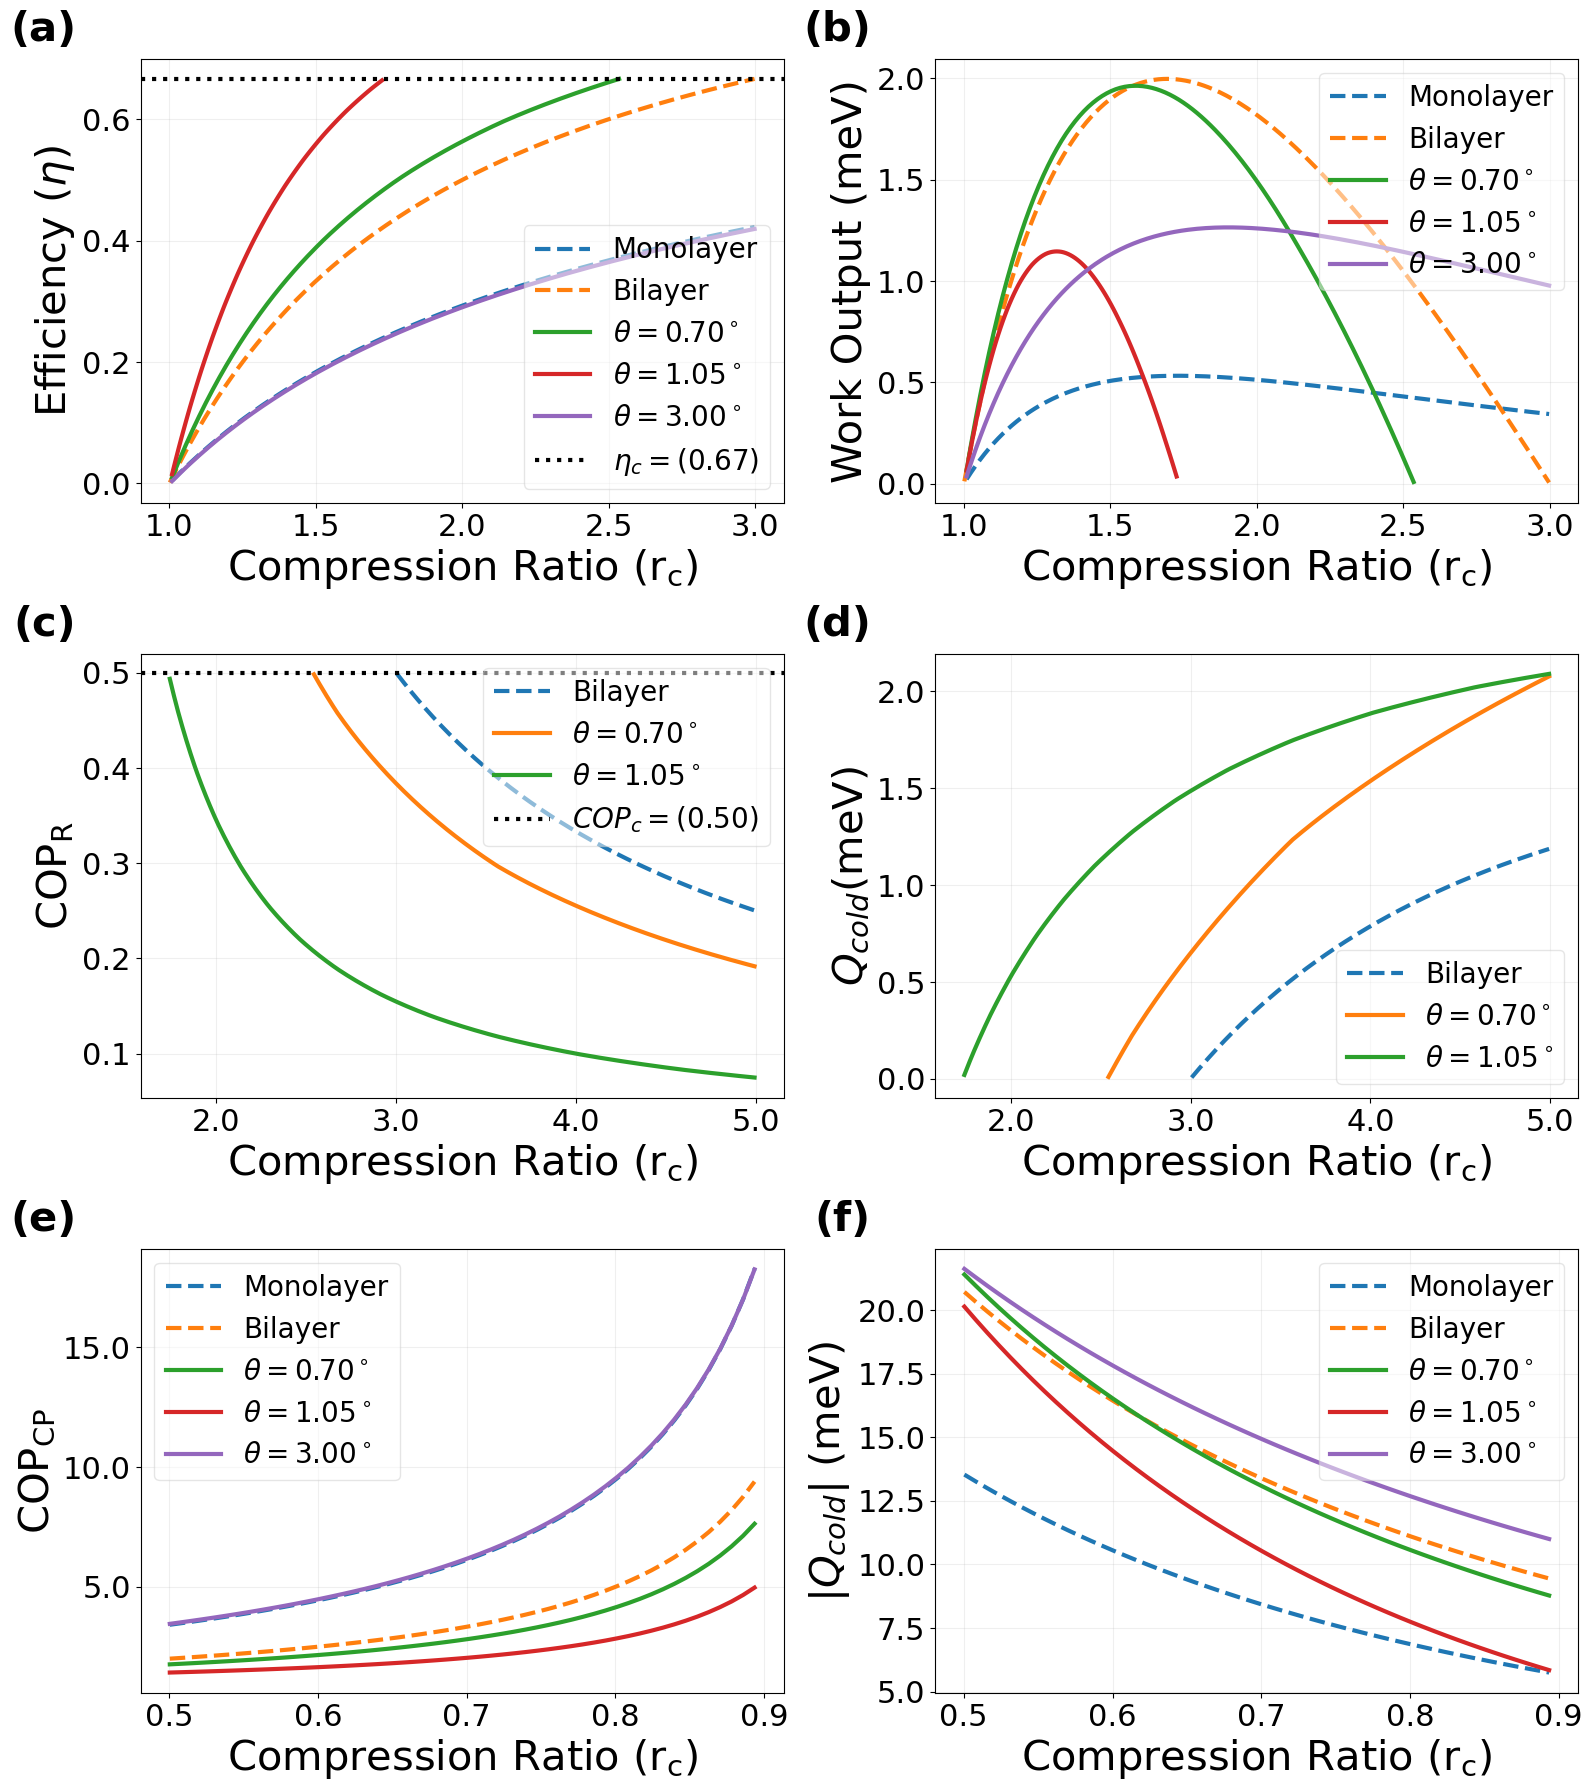

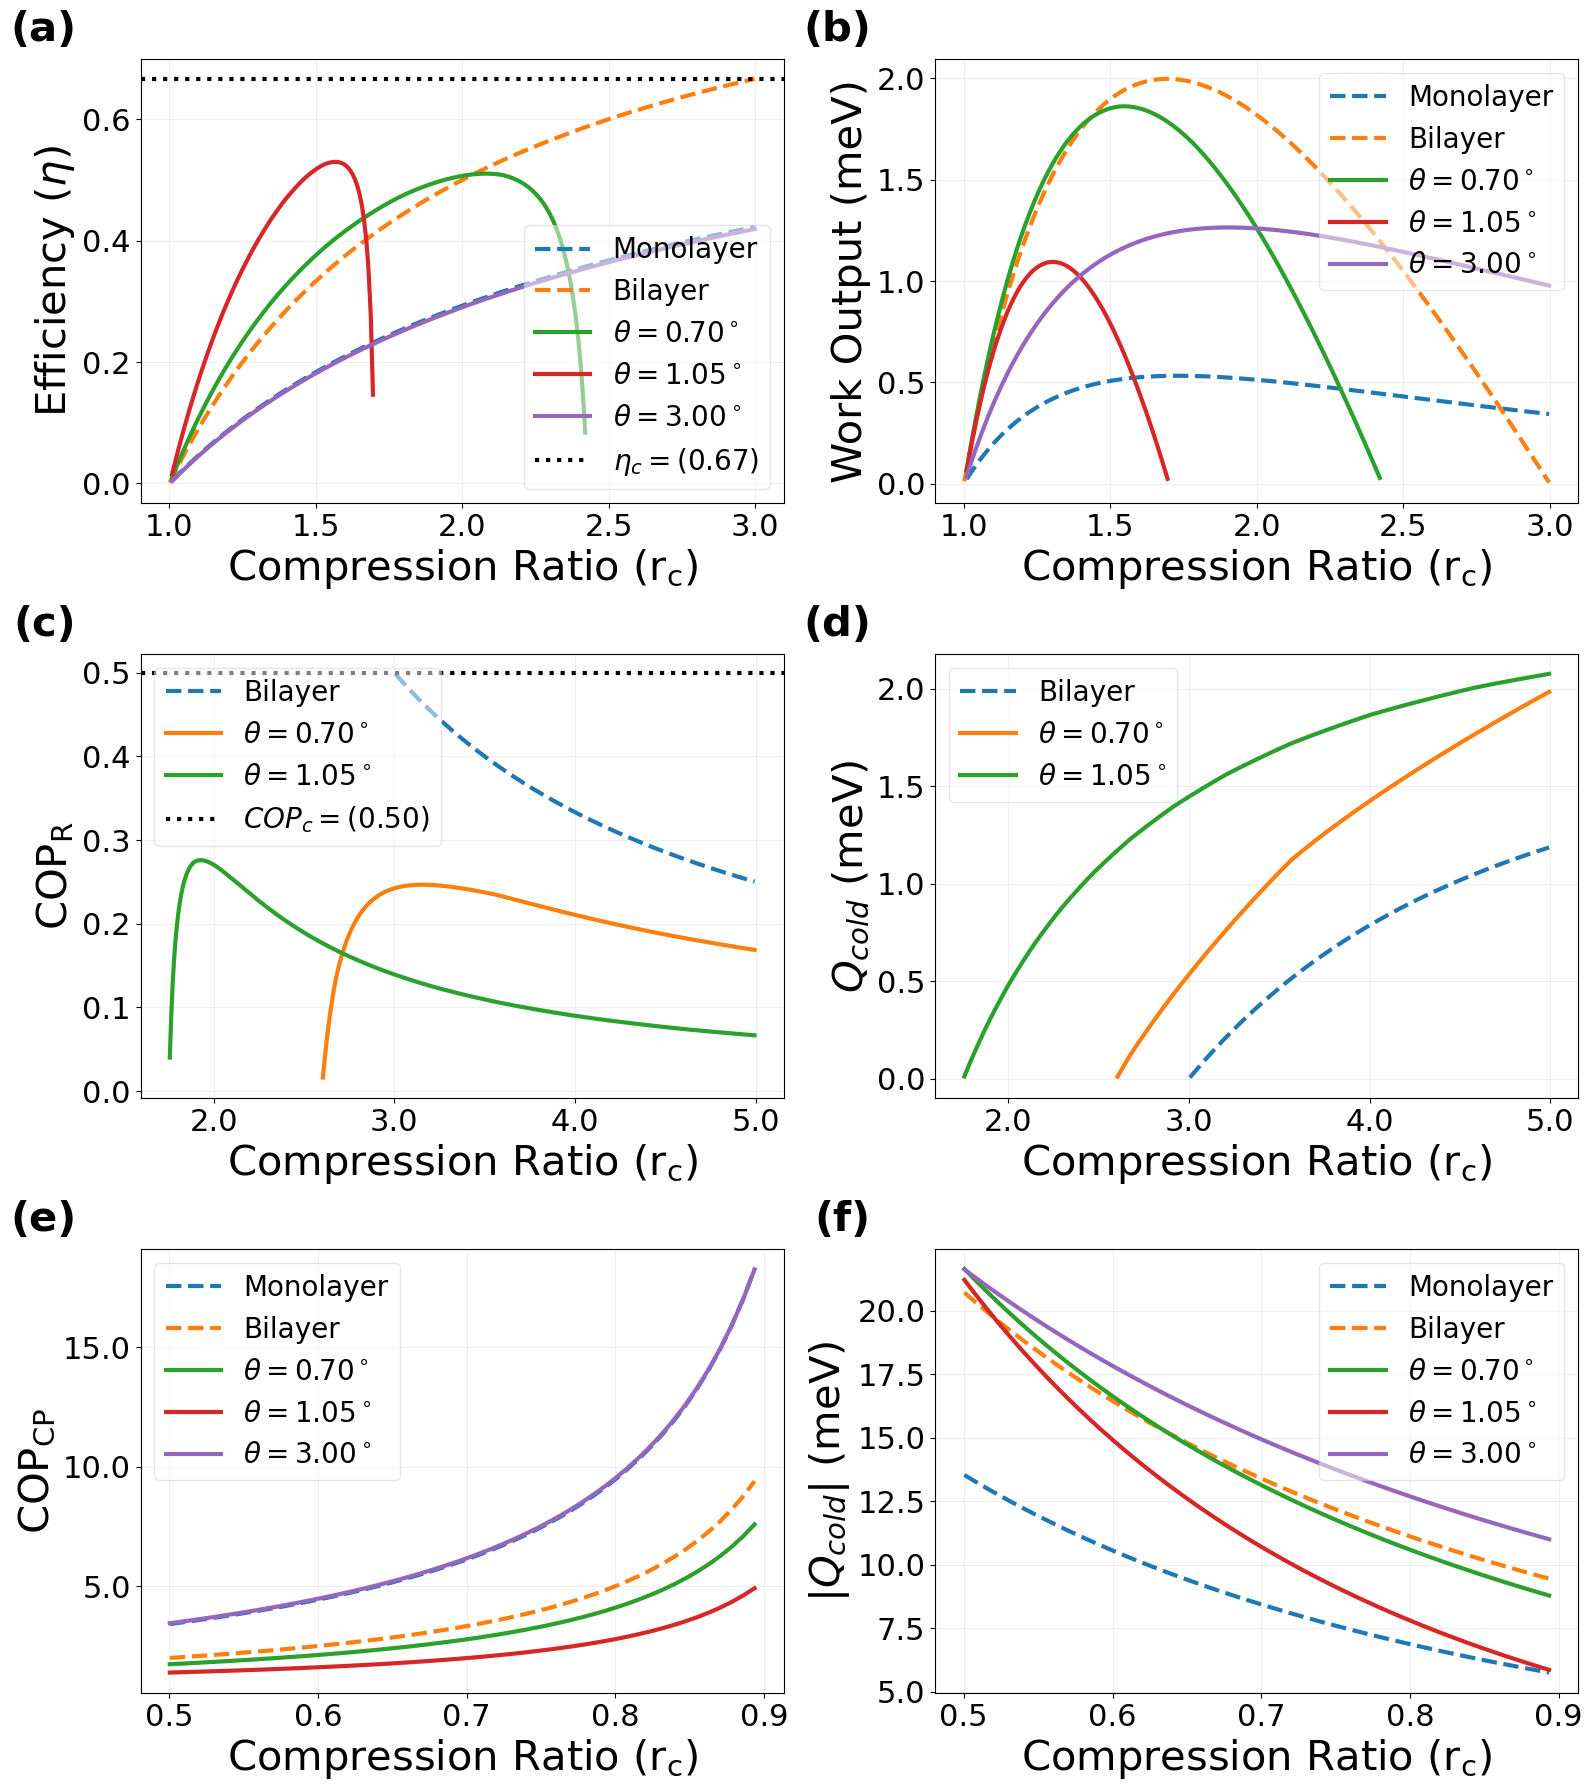

In [57]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Hot reservoir temperature (K)


c_eff = 1 - T_cold / T_hot  # Carnot efficiency
c_cop = T_cold / (T_hot - T_cold) # Carnot cop

B1 = 1  # Magnetic field in Tesla

Theta_deg = ["Monolayer", "Bilayer", 0.7,1.05,3]
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]

# Compression Ratios
Ratio = np.linspace(0.3, 8, 1000)

# Data Storage
all_efficiencies_HE_gen = {}
all_work_HE_gen = {}
all_rc_HE_gen={}

all_efficiencies_HE_strict = {}
all_work_HE_strict = {}
all_rc_HE_strict={}


all_cop_RE_gen = {}
all_Qc_RE_gen = {}
all_rc_RE_gen={}

all_cop_RE_strict = {}
all_Qc_RE_strict = {}
all_rc_RE_strict={}

all_cop_CP_gen = {}
all_Qc_CP_gen = {}
all_rc_CP_gen={}

all_cop_CP_strict = {}
all_Qc_CP_strict = {}
all_rc_CP_strict={}


# Loop over different angles
for theta in Theta:
    
    if isinstance(theta, (int, float)):  # If theta is a numerical value
        filename = f"spectrum_B_1T_N{N}_theta{np.round(np.degrees(theta),2)}_Ncon{N_con}_rc1000.npz"
        data = np.load(filename)
        B_vals = data["B_vals"]
        spectra = data["spectra"]    
        idx = np.argmin(np.abs(B_vals - B1))
        Energy_B1 = spectra[idx]
    elif theta == "Monolayer":
        Energy_B1 = hk_mono_LS(N_con, B1, 0, 0, True)
    elif theta == "Bilayer":
        Energy_B1 = bi_hk(N_con, B1, True)
        
    all_T_4, all_T_2 = [], []
    all_T_2.append(T_cold)
    all_T_4.append(T_hot)
    
    perf_HE_gen, output_HE_gen, rc_HE_gen= [], [],[]
    perf_HE_strict, output_HE_strict ,rc_HE_strict= [], [],[]
    
    perf_RE_gen, output_RE_gen, rc_RE_gen= [], [],[]
    perf_RE_strict, output_RE_strict ,rc_RE_strict= [], [],[]
    
    perf_CP_gen, output_CP_gen, rc_CP_gen= [], [],[]
    perf_CP_strict, output_CP_strict ,rc_CP_strict= [], [],[]
    
    Count = 0
    for rc in Ratio:
        Count += 1

        Heat_in_gen, Heat_out_gen, work_gen, eff_gen, COP_R_CP_gen, COP_JP_gen = QOC_General(
            B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Performance", saved=True)
        

        Heat_in_strict, Heat_out_strict, work_strict, eff_strict, COP_R_CP_strict, COP_JP_strict = QOC_Strict(
            B1, Energy_B1, rc, theta, T_cold, T_hot,Type="Performance", saved=True)

        if np.round(work_gen,5)==0:
            continue
        if np.round(work_strict,5)==0:
             continue

        if eff_gen is not None and work_gen > 0 and Heat_in_gen > 0 and Heat_out_gen < 0 and rc < 3 and rc > 1:
            output_HE_gen.append(work_gen*1000)  #meV
            perf_HE_gen.append(eff_gen)
            rc_HE_gen.append(rc)
            
        elif eff_gen is not None and work_gen < 0 and Heat_in_gen < 0 and Heat_out_gen > 0 and rc < 5:
            output_RE_gen.append(Heat_out_gen*1000)  #meV
            perf_RE_gen.append(COP_R_CP_gen)
            rc_RE_gen.append(rc)

        elif eff_gen is not None and work_gen < 0 and Heat_in_gen > 0 and Heat_out_gen < 0 and rc < 0.9 and rc > 0.5:
            output_CP_gen.append(np.abs(Heat_out_gen*1000))  #meV
            perf_CP_gen.append(COP_R_CP_gen)
            rc_CP_gen.append(rc)
            
        # Process strict results
        if eff_strict is not None and work_strict > 0 and Heat_in_strict > 0 and Heat_out_strict < 0 and rc < 3 and rc > 1:
            output_HE_strict.append(work_strict*1000)  #meV
            perf_HE_strict.append(eff_strict)
            rc_HE_strict.append(rc)
            
        elif eff_strict is not None and work_strict < 0 and Heat_in_strict < 0 and Heat_out_strict > 0  and rc < 5:
            output_RE_strict.append(Heat_out_strict*1000)  #meV
            perf_RE_strict.append(COP_R_CP_strict)
            rc_RE_strict.append(rc)

        elif eff_strict is not None and work_strict < 0 and Heat_in_strict > 0 and Heat_out_strict < 0 and rc < 0.9 and rc > 0.5:
            output_CP_strict.append(np.abs(Heat_out_strict*1000))  #meV
            perf_CP_strict.append(COP_R_CP_strict)
            rc_CP_strict.append(rc)
        
    all_efficiencies_HE_gen[theta] = perf_HE_gen
    all_work_HE_gen[theta] = output_HE_gen
    all_rc_HE_gen[theta] = rc_HE_gen

    all_efficiencies_HE_strict[theta] = perf_HE_strict
    all_work_HE_strict[theta] = output_HE_strict
    all_rc_HE_strict[theta] = rc_HE_strict


    all_cop_RE_gen[theta] = perf_RE_gen
    all_Qc_RE_gen[theta] = output_RE_gen
    all_rc_RE_gen[theta] = rc_RE_gen

    all_cop_RE_strict[theta] = perf_RE_strict
    all_Qc_RE_strict[theta] = output_RE_strict
    all_rc_RE_strict[theta] = rc_RE_strict

    all_cop_CP_gen[theta] = perf_CP_gen
    all_Qc_CP_gen[theta] = output_CP_gen
    all_rc_CP_gen[theta] = rc_CP_gen

    all_cop_CP_strict[theta] = perf_CP_strict
    all_Qc_CP_strict[theta] = output_CP_strict
    all_rc_CP_strict[theta] = rc_CP_strict






def plot_data(ax, x_data, y_data, theta_labels, ylabel, legend_loc='best', 
              carnot_line=None, subplot_label=None, show_xname=False):  # New: `show_xname`

    if subplot_label:
        ax.annotate(f'({subplot_label})', xy=(-0.10, 1.02), xycoords='axes fraction',
                    fontsize=30, weight='bold', ha='right', va='bottom')
    

    for theta, x, y in zip(Theta, x_data, y_data):
        if isinstance(theta, (int, float)):
            theta_label = f"$\\theta = {np.degrees(theta):.2f}^\\circ$"
            linestyle = "-"
        else:
            theta_label = theta
            linestyle = "--" if theta in ["Monolayer", "Bilayer"] else "-"
        
        if len(x) > 0 and len(y) > 0:
            ax.plot(x, y, label=theta_label, linestyle=linestyle, linewidth=3)
    
    if carnot_line is c_cop:
        ax.axhline(y=carnot_line, color='black', linestyle=':', linewidth=3, 
                   label=rf'$COP_c = ({carnot_line:.2f})$')

    elif carnot_line is c_eff:
        ax.axhline(y=carnot_line, color='black', linestyle=':', linewidth=3, 
                   label=rf'$\eta_c = ({carnot_line:.2f})$')
    

    ax.set_ylabel(ylabel, fontsize=30)
    

    if show_xname:
        ax.set_xlabel(r"Compression Ratio ($\text{r}_\text{c}$)", fontsize=30)  # Show only if `show_xname=True`
    else:
        ax.set_xlabel("")  # Hide otherwise
    
    ax.legend(fontsize=20, loc=legend_loc, framealpha=0.5)


fig1, axs1 = plt.subplots(3, 2, figsize=(16, 18))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Common settings
for ax in axs1.flat:
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.grid(True, alpha=0.2)
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

# Heat Engine - General
plot_data(axs1[0, 0], 
          [all_rc_HE_gen[theta] for theta in Theta], 
          [all_efficiencies_HE_gen[theta] for theta in Theta],
          Theta,
          r"Efficiency ($\eta$)", 
          carnot_line=c_eff,
          subplot_label='a',
          show_xname=True)

plot_data(axs1[0, 1], 
          [all_rc_HE_gen[theta] for theta in Theta], 
          [all_work_HE_gen[theta] for theta in Theta],
          Theta,
          r"Work Output (meV)", 
          subplot_label='b',
          show_xname=True)

# Refrigerator - General
plot_data(axs1[1, 0], 
          [all_rc_RE_gen[theta] for theta in Theta], 
          [all_cop_RE_gen[theta] for theta in Theta],
          Theta,
          r"$\mathrm{COP}_\mathrm{R}$",
          carnot_line=c_cop,
          subplot_label='c',
          show_xname=True)

plot_data(axs1[1, 1], 
          [all_rc_RE_gen[theta] for theta in Theta], 
          [all_Qc_RE_gen[theta] for theta in Theta],
          Theta,
          r"$Q_{cold}$(meV)", 
          subplot_label='d',
          show_xname=True)

# Heat Pump - General
plot_data(axs1[2, 0], 
          [all_rc_CP_gen[theta] for theta in Theta], 
          [all_cop_CP_gen[theta] for theta in Theta],
          Theta,
          r"$\mathrm{COP}_\mathrm{CP}$",
          subplot_label='e',
          show_xname=True)

plot_data(axs1[2, 1], 
          [all_rc_CP_gen[theta] for theta in Theta], 
          [all_Qc_CP_gen[theta] for theta in Theta],
          Theta,
          r"$|Q_{cold}|$ (meV)", 
          subplot_label='f',
          show_xname=True)

plt.tight_layout()
plt.show()


# Initialize figure for Strict cases
fig2, axs2 = plt.subplots(3, 2, figsize=(16, 18))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Common settings
for ax in axs2.flat:
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.grid(True, alpha=0.2)
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

# Heat Engine - Strict
plot_data(axs2[0, 0], 
          [all_rc_HE_strict[theta] for theta in Theta], 
          [all_efficiencies_HE_strict[theta] for theta in Theta],
          Theta,
          r"Efficiency ($\eta$)",
          legend_loc='lower right',
          carnot_line=c_eff,
          subplot_label='a',
          show_xname=True)

plot_data(axs2[0, 1], 
          [all_rc_HE_strict[theta] for theta in Theta], 
          [all_work_HE_strict[theta] for theta in Theta],
          Theta,
          r"Work Output (meV)", 
          subplot_label='b',
          show_xname=True)

# Refrigerator - Strict
plot_data(axs2[1, 0], 
          [all_rc_RE_strict[theta] for theta in Theta], 
          [all_cop_RE_strict[theta] for theta in Theta],
          Theta,
          r"$\mathrm{COP}_\mathrm{R}$",
          carnot_line=c_cop,
          subplot_label='c',
          show_xname=True)

plot_data(axs2[1, 1], 
          [all_rc_RE_strict[theta] for theta in Theta], 
          [all_Qc_RE_strict[theta] for theta in Theta],
          Theta,
          r"$Q_{cold}$ (meV)", 
          subplot_label='d',
          show_xname=True)

# Heat Pump - Strict
plot_data(axs2[2, 0], 
          [all_rc_CP_strict[theta] for theta in Theta], 
          [all_cop_CP_strict[theta] for theta in Theta],
          Theta,
          r"$\mathrm{COP}_\mathrm{CP}$",
          subplot_label='e',
          show_xname=True)

plot_data(axs2[2, 1], 
          [all_rc_CP_strict[theta] for theta in Theta], 
          [all_Qc_CP_strict[theta] for theta in Theta],
          Theta,
          r"$|Q_{cold}|$ (meV)", 
          subplot_label='f',
          show_xname=True)

plt.tight_layout()
plt.show()

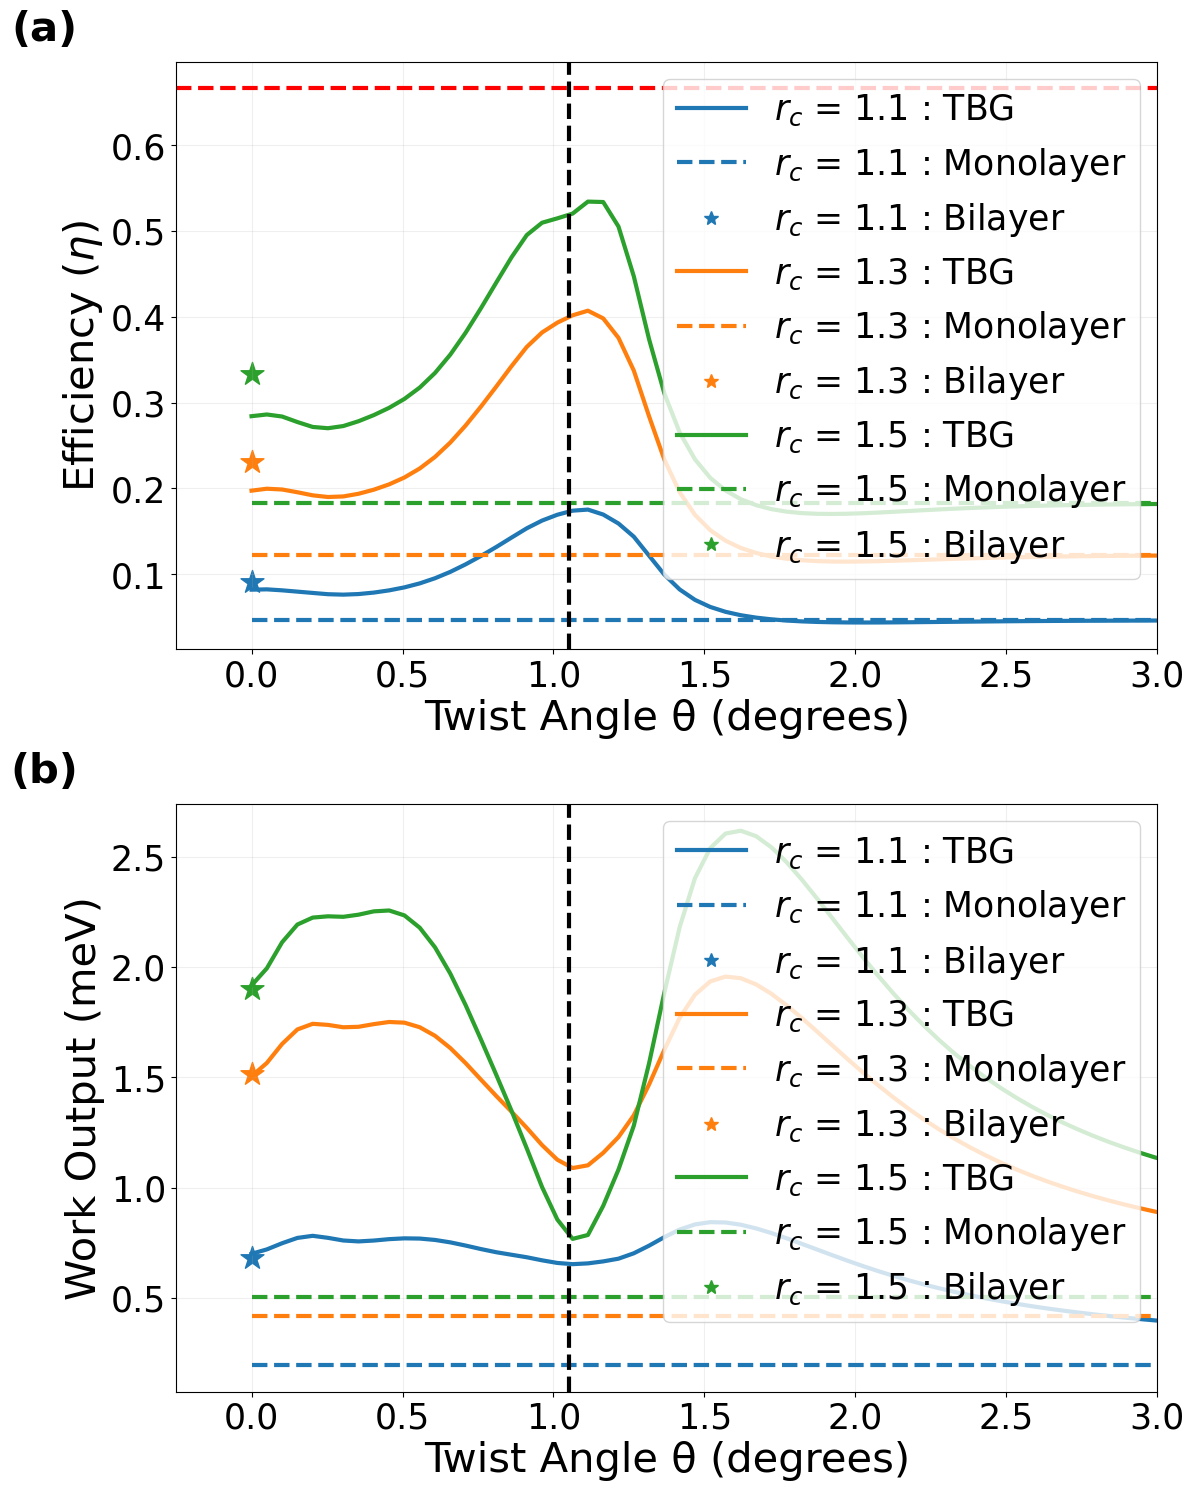

In [58]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Hot reservoir temperature (K)

B1 = 1  # Magnetic field in Tesla

carnot_eff= 1- T_cold/T_hot


Theta_deg = ["Monolayer", "Bilayer"] + np.linspace(0.0001, 4, 80).tolist()
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]


rc_values = [1.1, 1.3, 1.5]

# Dictionaries to store results
efficiencies_dict = {rc: [] for rc in rc_values}
work_dict = {rc: [] for rc in rc_values}

monolayer_eff = {rc: None for rc in rc_values}
bilayer_eff = {rc: None for rc in rc_values}
monolayer_work = {rc: None for rc in rc_values}
bilayer_work = {rc: None for rc in rc_values}
valid_theta_deg = []

for theta in Theta:
    all_T_4 , all_T_2=[] ,[]
    all_T_2.append(T_cold)
    all_T_4.append(T_hot)
    
    if isinstance(theta, (int, float)):
        data = np.load(f"spectrum_theta_sweep_N{N}_rc{B1}_Ncon{N_con}_steps80.npz")
        idx = np.argmin(np.abs(data["theta_vals_deg"] - np.round(np.degrees(theta), 2)))
        Energy_B1 = data["spectra"][idx]
    elif theta == "Monolayer":
        Energy_B1 = hk_mono_LS(N_con, B1, 0, 0, True)
    elif theta == "Bilayer":
        Energy_B1 = bi_hk(N_con, B1, True)
    
    # Check validity for all rc values
    valid = True
    temp_eff = {rc: None for rc in rc_values}
    temp_work = {rc: None for rc in rc_values}
    
    for rc in rc_values:

        #Heat_in, Heat_out, work, eff, _, _ = QOC_General(B1, Energy_B1, rc, theta, T_cold, T_hot, Type ="Twist",saved=True)
        
        Heat_in, Heat_out, work, eff, _, _ = QOC_Strict(B1, Energy_B1, rc, theta, T_cold, T_hot,Type ="Twist",saved=True)
        
        if eff is None or work is None:
            valid = False
            break
        temp_eff[rc] = eff
        temp_work[rc] = work *1000
    
    if not valid and isinstance(theta, (int, float)):
        continue
    
    if isinstance(theta, (int, float)):
        valid_theta_deg.append(np.degrees(theta))
    
    for rc in rc_values:
        if theta == "Monolayer":
            monolayer_eff[rc] = temp_eff[rc]
            monolayer_work[rc] = temp_work[rc]
        elif theta == "Bilayer":
            bilayer_eff[rc] = temp_eff[rc]
            bilayer_work[rc] = temp_work[rc]
        else:
            efficiencies_dict[rc].append(temp_eff[rc])
            work_dict[rc].append(temp_work[rc])


fig, axs = plt.subplots(2, 1, figsize=(12, 15))  # Wider layout for θ sweep
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True, alpha=0.2)


ax = axs[0]
legend_handles = []
legend_labels = []

for rc in rc_values:
    if efficiencies_dict[rc]:
        line, = ax.plot(valid_theta_deg, efficiencies_dict[rc], linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG')
        
        if monolayer_eff[rc] is not None:
            ax.hlines(monolayer_eff[rc], 0, max(valid_theta_deg),
                      colors=color, linestyles='dashed', linewidth=3)
            legend_handles.append(Line2D([], [], color=color, linestyle='--', linewidth=3))
            legend_labels.append(f'$r_c$ = {rc} : Monolayer')
        
        if bilayer_eff[rc] is not None:
            ax.scatter(0, bilayer_eff[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None',
                                         markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel(r'Efficiency ($\eta$)', fontsize=30)
ax.annotate(f'(a)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
ax.axhline(y=carnot_eff, color='red', linestyle='--', linewidth=3, label='Carnot Efficiency')
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
ax.set_xlim(-0.25, 3)
ax.legend(legend_handles, legend_labels, fontsize=25, loc='upper right')


ax = axs[1]
legend_handles = []
legend_labels = []

for rc in rc_values:
    if work_dict[rc]:
        line, = ax.plot(valid_theta_deg, work_dict[rc], linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG')
        
        if monolayer_work[rc] is not None:
            ax.hlines(monolayer_work[rc], 0, max(valid_theta_deg),
                      colors=color, linestyles='dashed', linewidth=3)
            legend_handles.append(Line2D([], [], color=color, linestyle='--', linewidth=3))
            legend_labels.append(f'$r_c$ = {rc} : Monolayer')
        
        if bilayer_work[rc] is not None:
            ax.scatter(0, bilayer_work[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel('Work Output (meV)', fontsize=30)
ax.annotate(f'(b)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
ax.set_xlim(-0.25, 3)
ax.legend(legend_handles, legend_labels, fontsize=25, loc='upper right')
plt.tight_layout()
plt.show()


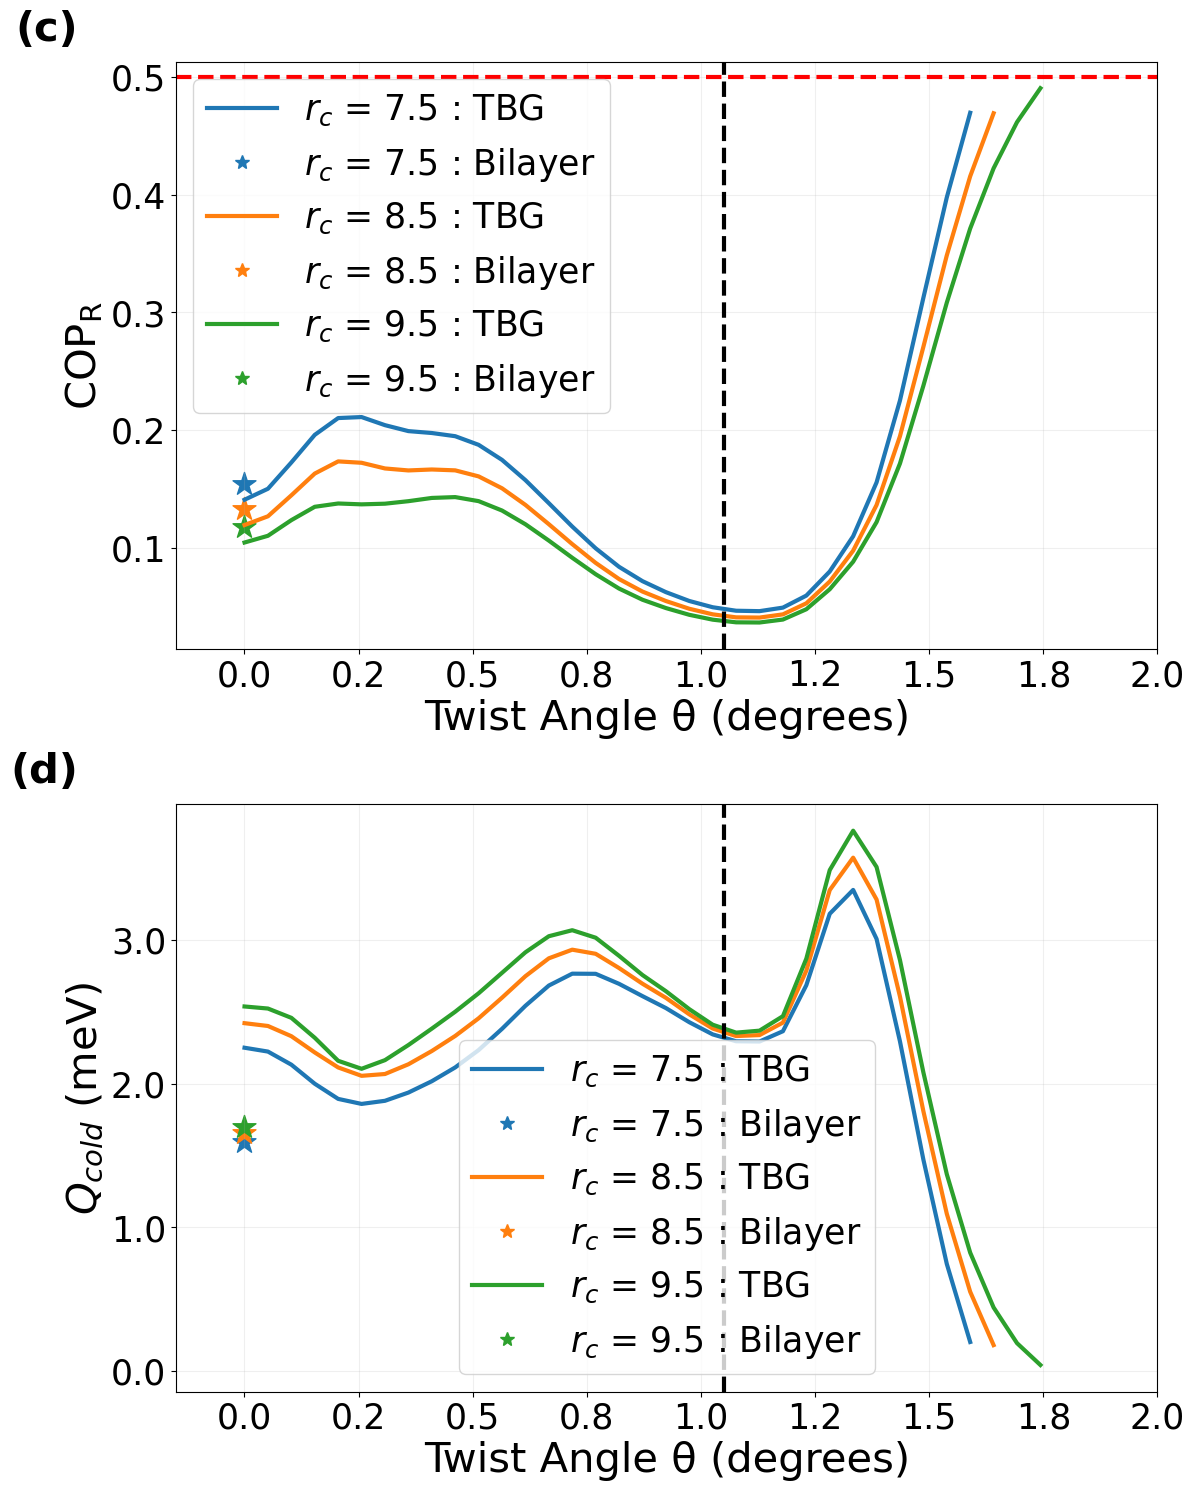

In [59]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Hot reservoir temperature (K)

B1 = 1  # Magnetic field in Tesla

carnot_cop= (T_cold/(T_hot-T_cold))


Theta_deg = [ "Bilayer"] + np.linspace(0.0001, 2, 40).tolist()
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]


rc_values = [7.5, 8.5,9.5]


cop_dict = {rc: [] for rc in rc_values}
work_dict = {rc: [] for rc in rc_values}


bilayer_cop = {rc: None for rc in rc_values}
bilayer_work = {rc: None for rc in rc_values}

# Track valid theta values
valid_theta_deg = []

for theta in Theta:

    if isinstance(theta, (int, float)):
        data = np.load(f"spectrum_theta_sweep_N{N}_rc{B1}_Ncon{N_con}_steps80.npz")
        idx = np.argmin(np.abs(data["theta_vals_deg"] - np.round(np.degrees(theta), 2)))
        Energy_B1 = data["spectra"][idx]
    elif theta == "Bilayer":
        Energy_B1 = bi_hk(N_con, B1, True)
    
    # Check validity for all rc values
    temp_cop = {rc: None for rc in rc_values}
    temp_work = {rc: None for rc in rc_values}
    
    for rc in rc_values:
        
        Heat_in, Heat_out, work, _, COP_R_CP, _ = QOC_General(B1, Energy_B1, rc, theta, T_cold, T_hot, Type ="Twist",saved=True)
        
        #Heat_in, Heat_out, work, _, COP_R_CP, _ = QOC_Strict(B1, Energy_B1, rc, theta, T_cold, T_hot,Type ="Twist",saved=True)
        

        if work < 0 and Heat_in < 0 and Heat_out > 0:
            
            temp_cop[rc] = COP_R_CP
            temp_work[rc] = Heat_out * 1000

    

    if any(v is not None for v in temp_cop.values()) or not isinstance(theta, (int, float)):
        if isinstance(theta, (int, float)):
            valid_theta_deg.append(np.degrees(theta))
        
        for rc in rc_values:
            if theta == "Bilayer":
                bilayer_cop[rc] = temp_cop[rc]
                bilayer_work[rc] = temp_work[rc]
            else:
                cop_dict[rc].append(temp_cop[rc])
                work_dict[rc].append(temp_work[rc])


fig, axs = plt.subplots(2, 1, figsize=(12,15))
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True, alpha=0.2)


ax = axs[0]
legend_handles = []
legend_labels = []

for rc in rc_values:
    valid_cop = [cop for cop in cop_dict[rc] if cop is not None]
    valid_theta = [theta for theta, cop in zip(valid_theta_deg, cop_dict[rc]) if cop is not None]
    
    if valid_cop:
        line, = ax.plot(valid_theta, valid_cop, linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG')

        if bilayer_cop[rc] is not None:
            ax.scatter(0, bilayer_cop[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel(r"$\mathrm{COP}_\mathrm{R}$", fontsize=30)
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
ax.annotate(f'(c)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
ax.axhline(y=carnot_cop, color='red', linestyle='--', linewidth=3, label='Carnot Efficiency')
ax.set_xlim(-0.15, 2)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.legend(legend_handles, legend_labels, fontsize=25, loc='best')


ax = axs[1]
legend_handles = []
legend_labels = []

for rc in rc_values:
    valid_work = [work for work in work_dict[rc] if work is not None]
    valid_theta = [theta for theta, work in zip(valid_theta_deg, work_dict[rc]) if work is not None]
    
    if valid_work:
        line, = ax.plot(valid_theta, valid_work, linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG')

        if bilayer_work[rc] is not None:
            ax.scatter(0, bilayer_work[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel(r'$Q_{cold}$ (meV)', fontsize=30)
ax.annotate(f'(d)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
ax.set_xlim(-0.15, 2)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.legend(legend_handles, legend_labels, fontsize=25, loc='best')
plt.tight_layout()
plt.show()


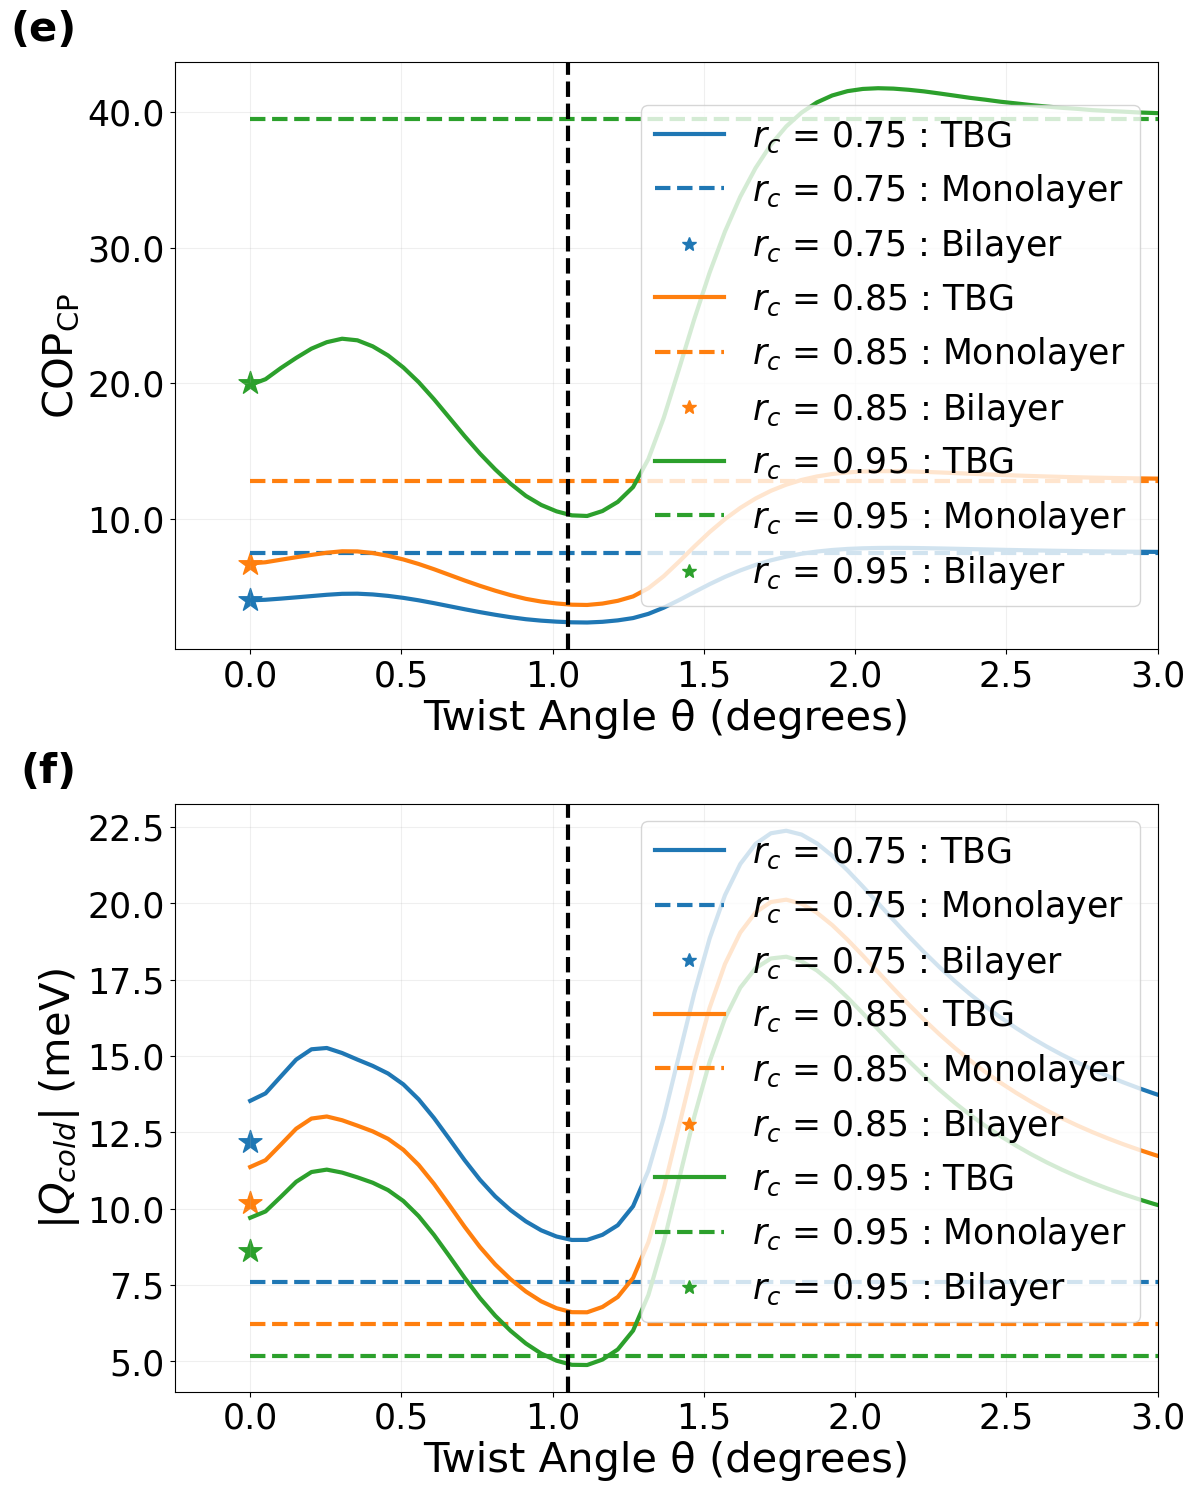

In [60]:
T_cold = 50  # Cold reservoir temperature (K)
T_hot = 150  # Hot reservoir temperature (K)
B1 = 1  # Magnetic field in Tesla

Theta_deg = ["Monolayer", "Bilayer"] + np.linspace(0.0001, 4, 80).tolist()
Theta = [np.radians(t) if isinstance(t, (int, float)) else t for t in Theta_deg]


rc_values = [0.75, 0.85, 0.95]

cop_dict = {rc: [] for rc in rc_values}
work_dict = {rc: [] for rc in rc_values}


monolayer_cop = {rc: None for rc in rc_values}
bilayer_cop = {rc: None for rc in rc_values}
monolayer_work = {rc: None for rc in rc_values}
bilayer_work = {rc: None for rc in rc_values}


valid_theta_deg = []

for theta in Theta:
    
    if isinstance(theta, (int, float)):
        data = np.load(f"spectrum_theta_sweep_N{N}_rc{B1}_Ncon{N_con}_steps80.npz")
        idx = np.argmin(np.abs(data["theta_vals_deg"] - np.round(np.degrees(theta), 2)))
        Energy_B1 = data["spectra"][idx]
    elif theta == "Monolayer":
        Energy_B1 = hk_mono_LS(N_con, B1, 0, 0, True)
    elif theta == "Bilayer":
        Energy_B1 = bi_hk(N_con, B1, True)
    

    temp_cop = {rc: None for rc in rc_values}
    temp_work = {rc: None for rc in rc_values}
    
    for rc in rc_values:
        
        Heat_in, Heat_out, work, _, COP_R_CP, _ = QOC_General(B1, Energy_B1, rc, theta, T_cold, T_hot, Type ="Twist",saved=True)
        
        #Heat_in, Heat_out, work, _, COP_R_CP, _ = QOC_Strict(B1, Energy_B1, rc, theta, T_cold, T_hot,Type ="Twist",saved=True)
        
        if work < 0 and Heat_in > 0 and Heat_out < 0:
            
            temp_cop[rc] = COP_R_CP
            temp_work[rc] = np.abs(Heat_out*1000)
    
    # Only store if at least one rc value was valid
    if any(v is not None for v in temp_cop.values()) or not isinstance(theta, (int, float)):
        if isinstance(theta, (int, float)):
            valid_theta_deg.append(np.degrees(theta))
        
        for rc in rc_values:
            if theta == "Monolayer":
                monolayer_cop[rc] = temp_cop[rc]
                monolayer_work[rc] = temp_work[rc]
            elif theta == "Bilayer":
                bilayer_cop[rc] = temp_cop[rc]
                bilayer_work[rc] = temp_work[rc]
            else:
                cop_dict[rc].append(temp_cop[rc])
                work_dict[rc].append(temp_work[rc])


fig, axs = plt.subplots(2, 1, figsize=(12, 15))
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.grid(True, alpha=0.2)

ax = axs[0]
legend_handles = []
legend_labels = []

for rc in rc_values:
    valid_cop = [cop for cop in cop_dict[rc] if cop is not None]
    valid_theta = [theta for theta, cop in zip(valid_theta_deg, cop_dict[rc]) if cop is not None]
    
    if valid_cop:
        line, = ax.plot(valid_theta, valid_cop, linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG ')
        
        if monolayer_cop[rc] is not None:
            ax.hlines(monolayer_cop[rc], 0, max(valid_theta), colors=color, linestyles='--', linewidth=3)
            legend_handles.append(Line2D([], [], color=color, linestyle='--', linewidth=3))
            legend_labels.append(f'$r_c$ = {rc} : Monolayer')
        
        if bilayer_cop[rc] is not None:
            ax.scatter(0, bilayer_cop[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel(r"$\mathrm{COP}_\mathrm{CP}$", fontsize=30)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
ax.annotate(f'(e)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
ax.set_xlim(-0.25, 3)
ax.legend(legend_handles, legend_labels, fontsize=25, loc='center right')


ax = axs[1]
legend_handles = []
legend_labels = []

for rc in rc_values:
    valid_work = [work for work in work_dict[rc] if work is not None]
    valid_theta = [theta for theta, work in zip(valid_theta_deg, work_dict[rc]) if work is not None]
    
    if valid_work:
        line, = ax.plot(valid_theta, valid_work, linewidth=3)
        color = line.get_color()
        legend_handles.append(Line2D([], [], color=color, linewidth=3))
        legend_labels.append(f'$r_c$ = {rc} : TBG')
        
        if monolayer_work[rc] is not None:
            ax.hlines(monolayer_work[rc], 0, max(valid_theta), colors=color, linestyles='--', linewidth=3)
            legend_handles.append(Line2D([], [], color=color, linestyle='--', linewidth=3))
            legend_labels.append(f'$r_c$ = {rc} : Monolayer')
        
        if bilayer_work[rc] is not None:
            ax.scatter(0, bilayer_work[rc], marker='*', s=300, color=color)
            legend_handles.append(Line2D([], [], color=color, marker='*', linestyle='None', markersize=10))
            legend_labels.append(f'$r_c$ = {rc} : Bilayer')

ax.set_xlabel('Twist Angle θ (degrees)', fontsize=30)
ax.set_ylabel(r'$|Q_{cold}|$ (meV)', fontsize=30)
ax.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)',linewidth=3)
ax.set_xlim(-0.25, 3)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.annotate(f'(f)', xy=(-0.10, 1.02), xycoords='axes fraction',fontsize=30, weight='bold', ha='right', va='bottom')
ax.legend(legend_handles, legend_labels, fontsize=25, loc='upper right')
plt.tight_layout()
plt.show()
